In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm


In [3]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 150

LAMBDA_L1 = 150
LAMBDA_EDGE = 50

SAVE_PATH = "/content/drive/MyDrive/pix2pix_sketch_G.pth"


In [4]:
class FS2KDataset(Dataset):

    def __init__(self, photo_dir, sketch_dir):

        self.photo_paths = sorted(glob.glob(photo_dir + "/*.jpg"))
        self.sketch_paths = sorted(glob.glob(sketch_dir + "/*.jpg"))

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):

        photo = Image.open(self.photo_paths[idx]).convert("L")
        sketch = Image.open(self.sketch_paths[idx]).convert("L")

        photo = self.transform(photo)
        sketch = self.transform(sketch)

        return photo, sketch


In [6]:
class FS2KDataset(Dataset):

    def __init__(self, root):

        self.photo_paths = sorted(glob.glob(root + "/photo/photo*/*.jpg"))
        self.sketch_paths = sorted(glob.glob(root + "/sketch/sketch*/*.jpg"))

        print("Photos found:", len(self.photo_paths))
        print("Sketches found:", len(self.sketch_paths))

        assert len(self.photo_paths) == len(self.sketch_paths), "Mismatch!"

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):

        photo = Image.open(self.photo_paths[idx]).convert("L")
        sketch = Image.open(self.sketch_paths[idx]).convert("L")

        return self.transform(photo), self.transform(sketch)


In [11]:
root = "/content/drive/MyDrive/FS2K"

dataset = FS2KDataset(root)

loader = DataLoader(
    dataset,

    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)


Valid pairs: 1533


In [12]:
import re

class FS2KDataset(Dataset):

    def __init__(self, root):

        photo_paths = glob.glob(root + "/photo/photo*/*.jpg")
        sketch_paths = glob.glob(root + "/sketch/sketch*/*.jpg")

        photo_dict = {}
        sketch_dict = {}

        # extract number from filename
        for path in photo_paths:
            num = re.findall(r'\d+', path)[-1]
            photo_dict[num] = path

        for path in sketch_paths:
            num = re.findall(r'\d+', path)[-1]
            sketch_dict[num] = path

        # keep only matching pairs
        common = sorted(set(photo_dict.keys()) & set(sketch_dict.keys()))

        self.photo_paths = [photo_dict[n] for n in common]
        self.sketch_paths = [sketch_dict[n] for n in common]

        print("Valid pairs:", len(self.photo_paths))

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):

        photo = Image.open(self.photo_paths[idx]).convert("L")
        sketch = Image.open(self.sketch_paths[idx]).convert("L")

        return self.transform(photo), self.transform(sketch)


In [13]:
class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)


In [19]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.d1 = Down(1,64)
        self.d2 = Down(64,128)
        self.d3 = Down(128,256)
        self.d4 = Down(256,512)

        self.u1 = Up(512,256)
        self.u2 = Up(512,128)
        self.u3 = Up(256,64)
        self.u4 = Up(128,64)

        # FIXED FINAL LAYER
        self.final = nn.Conv2d(64,1,1)

    def forward(self,x):

        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        u1 = self.u1(d4)
        u2 = self.u2(torch.cat([u1,d3],1))
        u3 = self.u3(torch.cat([u2,d2],1))
        u4 = self.u4(torch.cat([u3,d1],1))

        return torch.tanh(self.final(u4))


In [20]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(

            nn.Conv2d(2,64,4,2,1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128,256,4,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256,1,4,1,1)
        )

    def forward(self,x,y):
        return self.net(torch.cat([x,y],1))


In [21]:
def sobel(x):

    sobelx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],
                          dtype=torch.float32).view(1,1,3,3).to(DEVICE)

    sobely = sobelx.permute(0,1,3,2)

    gx = torch.nn.functional.conv2d(x,sobelx,padding=1)
    gy = torch.nn.functional.conv2d(x,sobely,padding=1)

    return torch.sqrt(gx**2 + gy**2)


In [22]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))

bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-3852915879.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [23]:
for epoch in range(EPOCHS):

    loop = tqdm(loader)

    for photo, sketch in loop:

        photo = photo.to(DEVICE)
        sketch = sketch.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():

            fake = G(photo)

            real = D(photo,sketch)
            fakeD = D(photo,fake.detach())

            lossD = (
                bce(real, torch.ones_like(real)) +
                bce(fakeD, torch.zeros_like(fakeD))
            ) / 2

        optD.zero_grad()
        scaler.scale(lossD).backward()
        scaler.step(optD)

        # Train Generator
        with torch.cuda.amp.autocast():

            fakeD = D(photo,fake)

            gan_loss = bce(fakeD, torch.ones_like(fakeD))
            l1_loss = l1(fake, sketch) * LAMBDA_L1
            edge_loss = l1(sobel(fake), sobel(sketch)) * LAMBDA_EDGE

            lossG = gan_loss + l1_loss + edge_loss

        optG.zero_grad()
        scaler.scale(lossG).backward()
        scaler.step(optG)
        scaler.update()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(lossG=lossG.item())

    torch.save(G.state_dict(), SAVE_PATH)

print("Training complete")


  0%|          | 0/384 [00:00<?, ?it/s]/tmp/ipython-input-2932708127.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2932708127.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [150/150]: 100%|██████████| 384/384 [00:46<00:00,  8.18it/s, lossG=nan]

Training complete


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files



In [3]:
class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)


class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.d1 = Down(1,64)
        self.d2 = Down(64,128)
        self.d3 = Down(128,256)
        self.d4 = Down(256,512)

        self.u1 = Up(512,256)
        self.u2 = Up(512,128)
        self.u3 = Up(256,64)
        self.u4 = Up(128,64)

        self.final = nn.Conv2d(64,1,1)

    def forward(self,x):

        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        u1 = self.u1(d4)
        u2 = self.u2(torch.cat([u1,d3],1))
        u3 = self.u3(torch.cat([u2,d2],1))
        u4 = self.u4(torch.cat([u3,d1],1))

        return torch.tanh(self.final(u4))


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "/content/drive/MyDrive/pix2pix_sketch_G.pth"

G = Generator().to(DEVICE)
G.load_state_dict(torch.load(model_path, map_location=DEVICE))
G.eval()

print("Model loaded")


Model loaded


In [5]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving image0032.jpg to image0032.jpg


In [6]:
img_color = Image.open(img_path).convert("RGB")
img_gray = img_color.convert("L")

orig_w, orig_h = img_color.size


In [7]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

input_tensor = transform(img_gray).unsqueeze(0).to(DEVICE)


In [8]:
with torch.no_grad():
    fake = G(input_tensor)


In [9]:
out = fake.squeeze().cpu().numpy()

# normalize correctly
out = (out + 1) / 2
out = np.clip(out, 0, 1)
out = (out * 255).astype(np.uint8)

# remove checkerboard noise safely
out = cv2.GaussianBlur(out, (5,5), 0)

# enhance contrast safely
out = cv2.normalize(out, None, 50, 255, cv2.NORM_MINMAX)

# sharpen safely
kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

out = cv2.filter2D(out, -1, kernel)

# brighten paper background
out = cv2.addWeighted(out, 0.9, np.full_like(out,255), 0.1, 0)

# resize back
final_sketch = cv2.resize(out, (orig_w, orig_h))


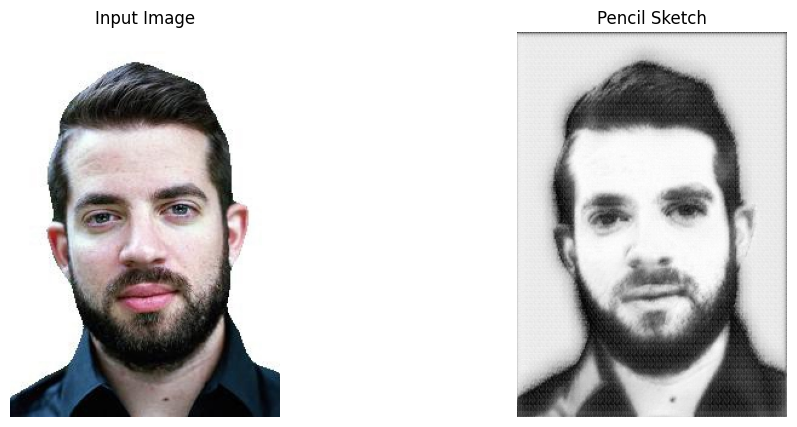

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img_color)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Pencil Sketch")
plt.imshow(final_sketch, cmap="gray")
plt.axis("off")

plt.show()
